# Sessionize EDGAR Apache Log Files

The goal is find out the following datapoints:

    - Top 10 download count by session
    - Top 10 download size by session

About the dataset
https://www.sec.gov/dera/data/edgar-log-file-data-set.html

About the individual fields
http://www.sec.gov/files/EDGAR_variables_FINAL.pdf

Dataset URL
http://www.sec.gov/dera/data/Public-EDGAR-log-file-data/2017/Qtr1/log20170201.zip


## Imports

In [52]:
%load_ext autoreload
%autoreload 2

# Imports
import logging
import tempfile
import zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import requests
from IPython.core.display_functions import display
from dask import dataframe as dd
from sqlalchemy import create_engine
from sqlalchemy.sql import text

from sessionizer import sessionize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialize
Prepare all essential directories and/or variables

In [51]:
# Files and folders
base_dir = Path().cwd()
data_dir = base_dir / 'data'
env_file = base_dir / '.env'
input_file = data_dir / 'data.csv'
sqlite_db_location = f'sqlite:///{str(data_dir / "db.sqlite3")}'
engine = create_engine(sqlite_db_location)
session_csv_file = data_dir / 'sessions.csv'
log_file = base_dir / 'application.log'

# Table names
log_table_name = 'log'
session_table_name = 'session'

for d in [data_dir]:
    if not d.exists():
        d.mkdir(parents=True)

# Logging
logging.basicConfig(filename=log_file,
                    filemode='a',
                    format='%(asctime)s %(name)s %(levelname)s %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.DEBUG)
logging.info('Process start')
logger = logging.getLogger('Sessionize EDGAR Apache Logs')

## Download file and unarchive

Do not download if file already exist and if `refresh` is not flagged as `True`

In [37]:
%%time

def get_file(refresh: bool) -> None:
    if not input_file.exists() or refresh:
        # Download the zip file
        response = requests.get('http://www.sec.gov/dera/data/Public-EDGAR-log-file-data/2017/Qtr1/log20170201.zip')
        assert response.status_code == 200

        # Save zip file to disk, extract, and rename
        with tempfile.NamedTemporaryFile(mode='wb') as zip_file:
            zip_file.write(response.content)
            with zipfile.ZipFile(zip_file.name, 'r') as f:
                file_list = f.filelist
                # only extract what is necessary while anticipating that the CSV file -
                # inside the ZIP file isn't always exactly named after it
                file_to_extract = next(f.filename for f in file_list if f.filename.endswith('.csv'))
                f.extract(file_to_extract, data_dir)
                extracted_file = data_dir / file_to_extract
                extracted_file.rename(input_file)
                logger.info('File has been downloaded and extracted into: %s', str(input_file))
    else:
        logger.info('File already exist. Will skip downloading the zip file.')


get_file(refresh=False)

CPU times: user 404 µs, sys: 134 µs, total: 538 µs
Wall time: 463 µs


## Arrange, filter, and load data

To make things run a little bit faster, we are going to use Dask.
We are only going to load the necessary columns for our use case.
For data warehousing, however, we should capture whatever data we can just in case we need it in the future. And of course, we will not be using Sqlite at all.

Loading and filtering 26.7 million rows of data took only roughly a minute.

```
CPU times: user 57.3 s, sys: 5.16 s, total: 1min 2s
Wall time: 49 s
```

Only the necessary columns will be loaded to the database in interest of performance:
- `ip` => Needed to pinpoint session and request origin
- `date` => Required for making a timestamp
- `time` => Required for making a timestamp
- `code` => Successful requests only. Those whose HTTP response code was in the line of 2xx
- `idx` => Only page visits that were not to an index page
- `size` => Needed to calculate the download size per session

In [38]:
%%time

# Reset table
with engine.connect() as con:
    con.execute(f'drop table if exists {log_table_name};')
    con.execute(f"""
        create table {log_table_name}
        (
            id   INTEGER PRIMARY KEY autoincrement,
            ip   TEXT,
            date DATETIME,
            size INTEGER
        );
    """)
    logger.info(f'Resetting table for log recording')


def load_data():
    """
    Load data into Sqlite DB using Dask.
    If blocksize is not specified, Dask will just default to 128MB.
    """
    logger.info('Loading CSV data to the database...')

    df = dd.read_csv(
        input_file,
        usecols=['ip', 'date', 'time', 'idx', 'code', 'size'],
        dtype={
            'date': str,
            'ip': str,
            'code': float,
            'size': float,
            'idx': float,
        },
    )

    df = (
        df
        # Only successful requests
        .query('code >= 200 & code < 300')
        # Exclude index page visits
        .query('idx == 0')
        # Concatenate date and time together to make a timestamp
        .assign(date=lambda x: x['date'] + ' ' + x['time'])
        .drop(columns=['time', 'code', 'idx'])
    )

    df.to_sql(log_table_name,
              uri=sqlite_db_location,
              if_exists='append',
              index=False)

    logger.info('Finished loading CSV data to the database')


load_data()

CPU times: user 58.8 s, sys: 5.97 s, total: 1min 4s
Wall time: 50.7 s



## Sessionize the log

Run the script located at `./sessionizer/sessionizer.py`

For the purposes of this coding challenge, we define a session in such a way that all actions of a user that happen within 30 minutes after the first action of a session belong to that session. We identify a user by the IP address.

In [ ]:
%%time

sessionize(chunksize=1000000)

## Rankings
1. Top 10 Sessions by Total Number of Downloaded Documents
2. Top 10 Sessions by Total Size of Downloaded Documents


In [98]:
def get_top_ranking(ranking_type: str) -> pd.DataFrame:
    assert ranking_type.lower() in ['download_count', 'download_size']

    with engine.connect() as con:
        query = f"""
        SELECT ip
            , session_start
            , session_end
            , {ranking_type}
        FROM session
        ORDER BY {ranking_type} DESC
        LIMIT 10
        """
        df = pd.read_sql_query(query, con=con, index_col='ip')

        if ranking_type == 'download_size':
            # Add gigabyte conversion - N Bytes / 1 billion = N Gigabytes
            df['Download Size (GB)'] = df[ranking_type].div(1000000000).round(2)

        return df

### Top 10 Sessions by Total Number of Downloaded Documents

,ip,session_start,session_end,download_count
0,128.175.241.beg,2017-02-01 00:00:00,2017-02-01 00:30:00,11203
1,161.253.85.gch,2017-02-01 02:00:04,2017-02-01 02:30:04,10832
2,161.253.85.gch,2017-02-01 02:30:05,2017-02-01 03:00:05,10396
3,161.253.85.gch,2017-02-01 03:00:06,2017-02-01 03:30:06,10135
4,128.91.90.aig,2017-02-01 00:33:22,2017-02-01 01:03:22,9791
5,205.132.129.hbc,2017-02-01 03:02:04,2017-02-01 03:32:04,9780
6,161.253.85.gch,2017-02-01 00:00:00,2017-02-01 00:30:00,9504
7,128.91.90.aig,2017-02-01 00:03:21,2017-02-01 00:33:21,9465
8,131.243.3.aed,2017-02-01 00:00:00,2017-02-01 00:30:00,8914
9,161.253.85.gch,2017-02-01 01:30:03,2017-02-01 02:00:03,8780


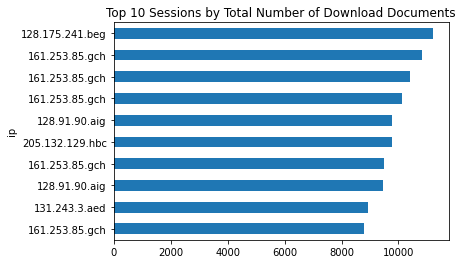

In [116]:
top_count = get_top_ranking(ranking_type='download_count')
(
    top_count['download_count']
    .sort_values()
    .plot(kind='barh', title='Top 10 Sessions by Total Number of Download Documents')
)

display(top_count.reset_index())
plt.show()

### Top 10 Sessions by Total Size of Download Documents

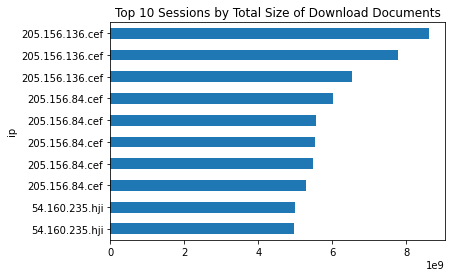

,ip,session_start,session_end,Download Size (GB)
0,205.156.136.cef,2017-02-01 00:51:35,2017-02-01 01:21:35,8.62
1,205.156.136.cef,2017-02-01 01:21:37,2017-02-01 01:51:37,7.78
2,205.156.136.cef,2017-02-01 01:51:41,2017-02-01 02:21:41,6.53
3,205.156.84.cef,2017-02-01 01:29:18,2017-02-01 01:59:18,6.01
4,205.156.84.cef,2017-02-01 00:29:15,2017-02-01 00:59:15,5.57
5,205.156.84.cef,2017-02-01 00:59:16,2017-02-01 01:29:16,5.54
6,205.156.84.cef,2017-02-01 02:29:20,2017-02-01 02:59:20,5.47
7,205.156.84.cef,2017-02-01 01:59:19,2017-02-01 02:29:19,5.28
8,54.160.235.hji,2017-02-01 00:00:51,2017-02-01 00:30:51,4.99
9,54.160.235.hji,2017-02-01 02:01:36,2017-02-01 02:31:36,4.96


In [117]:
# Top 10 by Size
top_count = get_top_ranking(ranking_type='download_size')
(
    top_count['download_size']
    .sort_values()
    .plot(kind='barh', title='Top 10 Sessions by Total Size of Download Documents')
)

plt.show()
display(top_count.drop(columns=['download_size']).reset_index())

### Top 10 Users by Download Count

Visualize the Top 10 users with the most downloads.
On top of that, visualize the total size of all their downloads.

,ip,download_count,download_size,min_date,max_date
0,161.253.85.gch,386255,1896756799,2017-02-01 00:00:00,2017-02-01 23:59:59
1,13.93.154.hjh,337044,672747570,2017-02-01 03:50:41,2017-02-01 08:28:15
2,217.174.255.dgd,287038,36302942260,2017-02-01 00:01:07,2017-02-01 23:51:57
3,68.180.231.abf,222926,3375028416,2017-02-01 00:00:00,2017-02-01 23:59:59
4,54.84.100.jga,203290,104150131651,2017-02-01 03:56:30,2017-02-01 23:59:59
5,128.138.64.edf,200910,91248906121,2017-02-01 00:00:00,2017-02-01 23:59:59
6,108.91.91.hbc,179697,6346202892,2017-02-01 00:00:17,2017-02-01 23:59:49
7,131.243.3.aed,176221,13854023724,2017-02-01 00:00:00,2017-02-01 18:02:19
8,52.119.57.ajg,147143,1448941696,2017-02-01 00:00:01,2017-02-01 21:49:53
9,108.39.205.jga,140191,42706648991,2017-02-01 00:39:40,2017-02-01 17:11:07


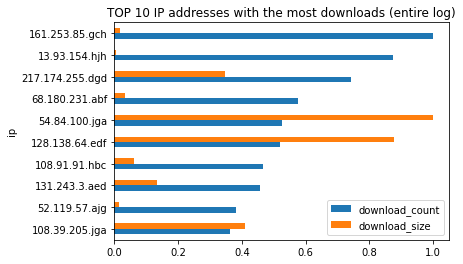

CPU times: user 9.03 s, sys: 803 ms, total: 9.83 s
Wall time: 9.79 s


In [111]:
%%time

def get_unique_users():
    with engine.connect() as con:
        df = pd.read_sql_query(f"""
            SELECT
                ip
                , COUNT(*) AS download_count
                , SUM(size) AS download_size
                , MIN([date]) AS min_date
                , MAX([date]) AS max_date
            FROM {log_table_name}
            GROUP BY ip
            ORDER BY download_count DESC
            LIMIT 10
        """, con=con)

        return df

unique_users = get_unique_users()
display(unique_users.head(10))
logger.info('Unique user count: %s', len(unique_users['ip']))

(
    unique_users.iloc[:10, :]
    .sort_values(['download_count'])
    .set_index('ip')
    .assign(
        # Normalize download size and count
        download_count=lambda x: x['download_count'] / x['download_count'].max(),
        download_size=lambda x: x['download_size'] / x['download_size'].max(),
    )
    .plot(kind='barh', title='TOP 10 IP addresses with the most downloads (entire log)')
)

plt.show()